### Black-Scholes
$$C(S_t, t) = N(d_+)S_t e^{-q(T-t)}-N(d_-)Ke^{-r(T-t)}$$
$$d_+ = \frac{1}{\sigma\sqrt{T-t}}\left[\ln\left(\frac{S_t}{K}\right)+\left(r-q+\frac{\sigma^2}{2}\right)(T-t)\right] $$
$$     d_- = d_+-\sigma\sqrt{T-t} $$

In [10]:
import numpy as np
from scipy.stats import norm

In [2]:
def Black_Scholes(call_put, sigma, K, T, t, St, r ,q):
    d_plus = (np.log(St/K)+(r-q+sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    d_minus = d_plus-sigma*np.sqrt(T-t)
    if(call_put=="call"):
        return norm.cdf(d_plus)*St*np.exp(-q*(T-t))- norm.cdf(d_minus)*K*np.exp(-r*(T-t))
    elif(call_put=="put"):
        return -norm.cdf(-d_plus)*St*np.exp(-q*(T-t))+ norm.cdf(-d_minus)*K*np.exp(-r*(T-t))
    else:
        raise ValueError("Please choose between call and put")

In [39]:
St=100
K=100
T=1.
t=0
r=.05
q=0.
sigma=.2
print("Black-Scholes call price: ",Black_Scholes("call", sigma, K, T, t, St, r, q))
print("Black-Scholes put price: ",Black_Scholes("put", sigma, K, T, t, St, r, q))


Black-Scholes call price:  10.450583572185572
Black-Scholes put price:  5.573526022256971


### Monte-Carlo simulation

In [31]:
def Monte_Carlo(call_put, sigma, K, T, t, St, r, q):
    n=10 #Number of time points
    dt=(T-t)/(n-1)
    N=50000 #Number of paths
    S=np.zeros((N,n))
    z=np.random.normal(0,1,(N,n))

    S[:,0]=St #Initialise all the paths at St at time t

    for j in range(1,n):
        S[:,j]=S[:,j-1]*np.exp((r-q-sigma**2/2)*dt+sigma*np.sqrt(dt)*z[:,j])

    if(call_put=="call"):
        return np.mean(np.max((S[:,n-1]-K,np.zeros(N)), axis=0))*np.exp(-r*(T-t))
    elif(call_put=="put"):
        return np.mean(np.max((K-S[:,n-1],np.zeros(N)), axis=0))*np.exp(-r*(T-t))
    else:
        raise ValueError("Please choose between call and put")

In [32]:
St=100
K=100
T=1.
t=0
r=.05
q=0.5
sigma=.2
print("Monte-Carlo call price: ",Monte_Carlo("call", sigma, K, T, t, St, r, q))
print("Monte-Carlo put price: ",Monte_Carlo("put", sigma, K, T, t, St, r, q))

Monte-Carlo call price:  0.05734459303845674
Monte-Carlo put price:  34.41750159866206


### Tree

In [5]:
def Tree(call_put, am_eu, sigma, K, T, t, St, r, q):
    n = 400  # Number of time periods
    dt = (T-t) / n
    S = np.zeros((n,n+1))
    U = np.exp(sigma*np.sqrt(dt))
    D = 1 / U

    S[0,0] = St

    for i in range(n-1):
        S[i+1,:i+1] = S[i,:i+1]*U
        S[i+1][i+1] = S[i][i]*D

    prices = np.zeros((n,n+1))
    if call_put == "call":
        prices[n-1,:] = np.max((S[n-1,:]-K, np.zeros(n+1)), axis=0)
    elif call_put == "put":
        prices[n-1,:] = np.max((K-S[n-1,:], np.zeros(n+1)), axis=0)
    else:
        raise ValueError("Please choose between call and put")

    p = (np.exp((r-q)*dt)-D)/(U-D)
    if am_eu == "European":
        for i in range(n-2, -1, -1):
            for j in range(i+1):
                prices[i,j] = (p*prices[i+1,j] + (1-p)*prices[i+1,j+1])*np.exp(-r*dt)
    elif am_eu == "American":
        if call_put == "call":
            for i in range(n-2, -1, -1):
                for j in range(i+1):
                    prices[i,j] = np.maximum((p*prices[i+1,j] + (1-p)*prices[i+1,j+1])*np.exp(-r*dt), S[i,j]-K)
        elif call_put == "put":
            for i in range(n-2, -1, -1):
                for j in range(i+1):
                    prices[i,j] = np.maximum((p*prices[i+1,j] + (1-p)*prices[i+1,j+1])*np.exp(-r*dt), K-S[i,j])
        else:
            raise ValueError("Please choose American or European.")

    return prices[0,0]

In [47]:
St=100
K=100
T=1.
t=0
r=.05
q=0.
sigma=.2

print("Binomial European tree call price: ", Tree("call", "European", sigma, K, T, t, St, r, q))
print("Binomial European tree put price: ", Tree("put", "European", sigma, K, T, t, St, r, q))

print("Binomial American tree call price: ", Tree("call", "American", sigma, K, T, t, St, r, q))
print("Binomial American tree put price: ", Tree("put", "American", sigma, K, T, t, St, r, q))

Binomial European tree call price:  10.43893173730427
Binomial European tree put price:  5.573765298364829


Binomial American tree call price:  10.43893173730427
Binomial American tree put price:  6.088405897039062


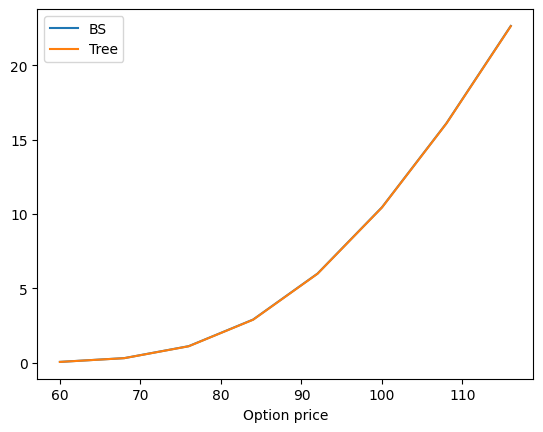

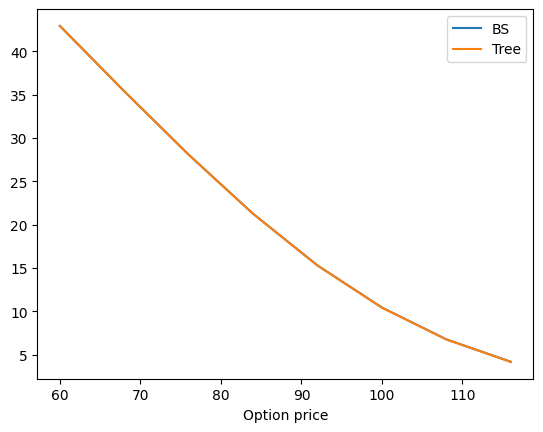

In [52]:
S = np.arange(60,120,8)
prices_BS = Black_Scholes("call", sigma, K, T, t, S, r,q)
prices_tree = [Tree("call", "European", sigma, K, T, t, St, r, q) for St in S]

plt.plot(S, prices_BS, label="BS")
plt.plot(S, prices_tree, label="Tree")
plt.xlabel("Stock price")
plt.ylabel("Option price")
plt.legend()
plt.show()

St=100
Ks = np.arange(60,120,8)
prices_BS = Black_Scholes("call", sigma, Ks, T, t, St, r,q)
prices_tree = [Tree("call", "European", sigma, K, T, t, St, r, q) for K in Ks]

plt.plot(S, prices_BS, label="BS")
plt.plot(S, prices_tree, label="Tree")
plt.xlabel("Strike price")
plt.ylabel("Option price")
plt.legend()
plt.show()

### PDE

$$\frac{\partial V}{\partial t}+\frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}+ (r-q)S\frac{\partial V}{\partial S}- rV = 0$$
$$\Theta+\frac{1}{2}\sigma^2 S^2 \Gamma+ (r-q)S \Delta- rV = 0$$
We can discretize the Greeks (I choose to use the explicit method, ie backward approximation for $\Theta$, central approximation for $\Delta$ and standard approximation for $\Gamma$):
$$\Theta =\frac{\partial V}{\partial t} = \frac{V(t_i,S_j)-V(t_{i-1},S_j)}{\delta t}$$
$$\Gamma =\frac{\partial^2 V}{\partial S^2}= \frac{V(t_i,S_{j+1})-2V(t_i,S_j)+V(t_i,S_{j-1})}{(\delta S)^2}$$
$$ \Delta =\frac{\partial V}{\partial S}= \frac{V(t_i,S_{j+1})-V(t_i,S_{j-1})}{2\delta S}$$
Thus, we have:
$$V(t_{i-1},S_j)=(1-r \delta t) V(t_i,S_j)+\frac{1}{2}\sigma^2 \delta t S_j^2 \frac{V(t_i,S_{j+1})+2V(t_i,S_j)+V(t_i,S_{j-1})}{(\delta S)^2}+(r-q) \delta t S_j \frac{V(t_i,S_{j+1})-V(t_i,S_{j-1})}{2\delta S}$$
$$V(t_{i-1},S_j)= a_j V(t_i,S_{j-1})+b_j V(t_i, S_j)+c_j V(t_i, S_{j+1})$$
with $a_j=\frac{1}{2} \delta t (\sigma^2 j^2-(r-q)j) $, $b_j=1-\delta t (\sigma^2 j^2 +r)$ and $c_j=\frac{1}{2} \delta t (\sigma^2 j^2+(r-q)j)$ using $S_j=j \delta S$.

We set boundaries conditions:
$$ \forall i, V(t_i,0) = 0 $$
$$ \forall i, V(t_i, S_j) \underset{S_j \rightarrow \infty}{\sim} S_j-K e^{-r(T-t_i)}$$
$$ \forall j, V(T, S_j) = \max(S_j-K, 0)$$

In [1]:
import numpy as np

In [2]:
def PDE(call_put, am_eu, sigma, K, T, St, r, q):
    #S_min =0.;
    #S_max= St*(1+8*sigma*np.sqrt(T))  #good maximum value for a lognormal distribution
    S_max = St*(1+2*sigma*np.sqrt(T))  
    n_t = 1000  # Number of time points
    n_S = 50  # Number of price points
    dt = T/(n_t-1)
    dS = S_max/(n_S-1)
    V = np.zeros((n_t,n_S))

    if dt*sigma*sigma*n_S*n_S > 1:
        print("Change the parameters in order to assure the stability.")

    if call_put == "call":
        #V[:,0] = 0
        for i in range(n_t):
            V[i,n_S-1] = S_max-K*np.exp(-r*(T-i*dt))
        for j in range(n_S):
            V[n_t-1,j] = np.max((j*dS-K, 0))
    elif call_put == "put":
        #V[:,n_S-1] = 0
        for i in range(n_t):
            V[i,0] = K*np.exp(-r*(T-i*dt))
        for j in range(n_S):
            V[n_t-1,j] = np.max((K-j*dS, 0))
    else:
        raise ValueError("Please choose between call and put")

    if am_eu=="European":
        for i in range(n_t-1, 0, -1):
            for j in range(1, n_S-1):
                a = 0.5*dt*(sigma**2*j**2-(r-q)*j)
                b = 1-dt*(sigma**2*j**2+r)
                c = 0.5*dt*(sigma**2*j**2+(r-q)*j)
                V[i-1,j] = a*V[i,j-1]+b*V[i,j]+c*V[i,j+1]
    elif am_eu=="American":
        if call_put=="call":
            for i in range(n_t-1, 0, -1):
                for j in range(1, n_S-1):
                    a = 0.5*dt*(sigma**2*j**2-(r-q)*j)
                    b = 1-dt*(sigma**2*j**2+r)
                    c = 0.5*dt*(sigma**2*j**2+(r-q)*j)
                    V[i-1,j] = np.max((a*V[i,j-1]+b*V[i,j]+c*V[i,j+1], j*dS-K))
        elif call_put=="put":
            for i in range(n_t-1, 0, -1):
                for j in range(1, n_S-1):
                    a = 0.5*dt*(sigma**2*j**2-(r-q)*j)
                    b = 1-dt*(sigma**2*j**2+r)
                    c = 0.5*dt*(sigma**2*j**2+(r-q)*j)
                    V[i-1,j] = np.max((a*V[i,j-1]+b*V[i,j]+c*V[i,j+1], K-j*dS))
    else:
        raise ValueError("Please choose between American and European")

    return V[0,round(St/dS)]


In [4]:
St=100
K=100
T=1.
t=0
r=.05
q=0.5
sigma=.2

print("PDE European tree call price: ", PDE("call", "European", sigma, K, T, St, r, q))
print("PDE European tree put price: ", PDE("put", "European", sigma, K, T, St, r, q))
print("PDE American tree call price: ", PDE("call", "American", sigma, K, T, St, r, q))
print("PDE American tree put price: ", PDE("put", "American", sigma, K, T, St, r, q))

PDE European tree call price:  0.06197464149155533


PDE European tree put price:  34.533300076573006
PDE American tree call price:  1.4614208433293352
PDE American tree put price:  34.533300076579145


## Greeks

### Delta

In [2]:
import numpy as np
from scipy.stats import norm

In [30]:
def delta_BS(call_put, sigma, K, T, t, St, r, q):
    d_plus = (np.log(St/K) + (r-q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    if call_put == "call":
        return norm.cdf(d_plus, 0, 1)*np.exp(-q*(T-t))
    elif call_put == "put":
        return -norm.cdf(-d_plus, 0, 1)*np.exp(-q*(T-t))
    else:
        raise ValueError("Please choose between call and put")
    
def delta_num(call_put, am_eu, sigma, K, T, t, St, r, q, dS=.01):
    return (Tree(call_put, am_eu, sigma, K, T, t, St+dS, r, q)-Tree(call_put, am_eu, sigma, K, T, t, St-dS, r, q))/(2*dS)

In [6]:
St=100
K=105
T=1.
t=0
r=.05
q=0.
sigma=.2

print("Delta BS European call price: ", delta_BS("call", sigma, K, T, t, St, r, q))
print("Delta BS European put price: ", delta_BS("put", sigma, K, T, t, St, r, q))
print("Delta numerical European tree call price: ", delta_num("call", "European", sigma, K, T, t, St, r, q))
print("PDE numerical European tree put price: ", delta_num("put", "European", sigma, K, T, t, St, r, q))
print("Delta numerical American tree call price: ", delta_num("call", "American", sigma, K, T, t, St, r, q))
print("PDE numerical American tree put price: ", delta_num("put", "American", sigma, K, T, t, St, r, q))

Delta BS European call price:  0.5422283335848053
Delta BS European put price:  -0.4577716664151948


Delta numerical European tree call price:  0.5594477801660336
PDE numerical European tree put price:  -0.44055221982075565
Delta numerical American tree call price:  0.5594477801660336
PDE numerical American tree put price:  -0.5226811497484718


In [10]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


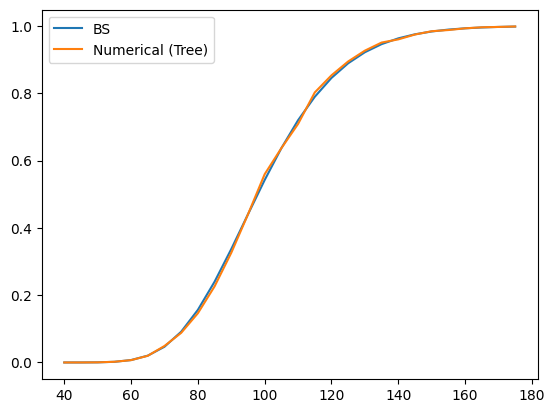

In [25]:
S = np.arange(40,180,5)
deltas_BS = delta_BS("call", sigma, K, T, t, S, r,q)
deltas_num = [delta_num("call", "European", sigma, K, T, t, St, r,q) for St in S]

plt.plot(S, deltas_BS, label="BS")
plt.plot(S, deltas_num, label="Numerical (Tree)")
plt.legend()

### Gamma

In [35]:
def gamma_BS(call_put, sigma, K, T, t, St, r, q):
    d_plus = (np.log(St/K) + (r-q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    return norm.pdf(d_plus, 0, 1)*np.exp(-q*(T-t))/(St*sigma*np.sqrt(T-t))
    
def gamma_num(call_put, am_eu, sigma, K, T, t, St, r, q, dS=1e-5, method="tree"):
    if method=="BS":
        return (Black_Scholes(call_put, sigma, K, T, t, St+dS, r, q)-2*Black_Scholes(call_put, sigma, K, T, t, St, r, q)+Black_Scholes(call_put, sigma, K, T, t, St-dS, r, q))/(dS**2)
    elif method=="tree":
        return (Tree(call_put, am_eu, sigma, K, T, t, St+dS, r, q)-2*Tree(call_put, am_eu, sigma, K, T, t, St, r, q)+Tree(call_put, am_eu, sigma, K, T, t, St-dS, r, q))/(dS**2)
    else:
        raise ValueError("Please choose between BS and tree")

In [64]:
St=100
K=100
T=1.
t=0
r=.05
q=0.
sigma=.2

print("Gamma BS European: ", gamma_BS("call", sigma, K, T, t, St, r, q))
print("Gamma numerical European tree: ", gamma_num("call", "European", sigma, K, T, t, St, r, q))
print("Gamma numerical American tree: ", gamma_num("call", "American", sigma, K, T, t, St, r, q))


Gamma BS European:  0.018762017345846895


Gamma numerical European tree:  8.881784197001251e-05
Gamma numerical American tree:  8.881784197001251e-05


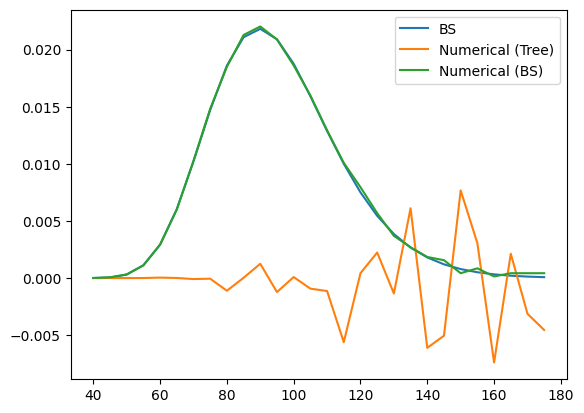

In [53]:
S = np.arange(40,180,5)
gammas_BS = gamma_BS("call", sigma, K, T, t, S, r,q)
gammas_num_tree = [gamma_num("call", "European", sigma, K, T, t, St, r, q, method="tree") for St in S]
gammas_num_BS = gamma_num("call", "European", sigma, K, T, t, S, r, q, method="BS")

plt.plot(S, gammas_BS, label="BS")
plt.plot(S, gammas_num_tree, label="Numerical (Tree)")
plt.plot(S, gammas_num_BS, label="Numerical (BS)")
plt.legend()

### Vega

In [62]:
def vega_BS(call_put, sigma, K, T, t, St, r, q):
    d_plus = (np.log(St/K) + (r-q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    return norm.pdf(d_plus, 0, 1)*St*np.sqrt(T-t)*np.exp(-q*(T-t))
    
def vega_num(call_put, am_eu, sigma, K, T, t, St, r, q, ds=1e-5):
    return (Tree(call_put, am_eu, sigma+ds, K, T, t, St, r, q)-Tree(call_put, am_eu, sigma-ds, K, T, t, St, r, q))/(2*ds)

In [72]:
St=100
K=100
T=1.
t=0
r=.05
q=0.3
sigma=.2

print("Vega BS European: ", vega_BS("call", sigma, K, T, t, St, r, q))
print("Vega numerical European tree: ", vega_num("call", "European", sigma, K, T, t, St, r, q))
print("Vega numerical American tree: ", vega_num("call", "American", sigma, K, T, t, St, r, q))


Vega BS European:  15.256134016696384
Vega numerical European tree:  15.289781584859606
Vega numerical American tree:  23.38615228392182


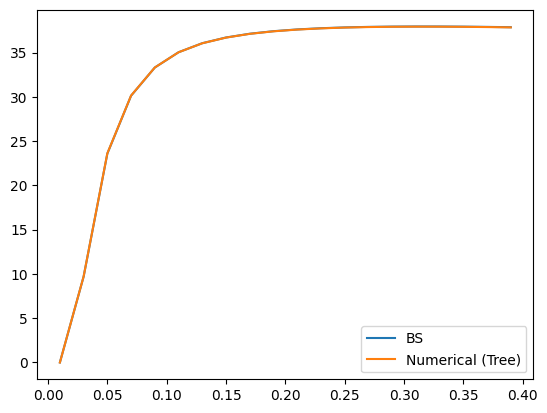

In [65]:
sigmas = np.arange(0.01,.4,.02)
vegas_BS = vega_BS("call", sigmas, K, T, t, St, r,q)
vegas_num = [vega_num("call", "European", sigma, K, T, t, St, r,q) for sigma in sigmas]

plt.plot(sigmas, vegas_BS, label="BS")
plt.plot(sigmas, vegas_num, label="Numerical (Tree)")
plt.legend()

### Theta

In [79]:
def theta_BS(call_put, sigma, K, T, t, St, r, q):
    d_plus = (np.log(St/K) + (r-q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    d_minus = d_plus- sigma*np.sqrt(T-t) 
    if call_put == "call":
        return -np.exp(-q*(T-t))*St*norm.pdf(d_plus,0,1)*sigma/(2*np.sqrt(T-t))-r*K*np.exp(-r*(T-t))*norm.cdf(d_minus,0,1)+q*St*np.exp(-q*(T-t))*norm.cdf(d_plus,0,1)
    elif call_put == "put":
        return -np.exp(-q*(T-t))*St*norm.pdf(d_plus,0,1)*sigma/(2*np.sqrt(T-t))+r*K*np.exp(-r*(T-t))*norm.cdf(-d_minus,0,1)-q*St*np.exp(-q*(T-t))*norm.cdf(-d_plus,0,1)
    else:
        raise ValueError("Please choose between call and put")
    
def theta_num(call_put, am_eu, sigma, K, T, t, St, r, q, dt=.01):
    return (Tree(call_put, am_eu, sigma, K, T, t+dt, St, r, q)-Tree(call_put, am_eu, sigma, K, T, t-dt, St, r, q))/(2*dt)

In [80]:
St=100
K=100
T=1.
t=0
r=.05
q=0.
sigma=.2

print("Theta BS European call price: ", theta_BS("call", sigma, K, T, t, St, r, q))
print("Theta BS European put price: ", theta_BS("put", sigma, K, T, t, St, r, q))
print("Theta numerical European tree call price: ", theta_num("call", "European", sigma, K, T, t, St, r, q))
print("PDE numerical European tree put price: ", theta_num("put", "European", sigma, K, T, t, St, r, q))
print("Theta numerical American tree call price: ", theta_num("call", "American", sigma, K, T, t, St, r, q))
print("PDE numerical American tree put price: ", theta_num("put", "American", sigma, K, T, t, St, r, q))

Theta BS European call price:  -6.414027546438197
Theta BS European put price:  -1.657880423934626
Theta numerical European tree call price:  -6.404902207002827
PDE numerical European tree put price:  -1.66005218655636


Theta numerical American tree call price:  -6.404902207002827
PDE numerical American tree put price:  -2.2373274974185176


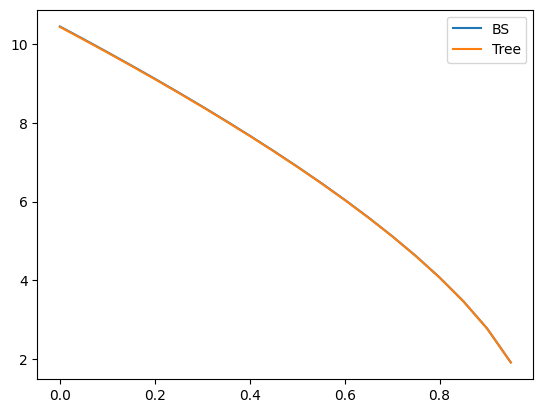

In [69]:
ts = np.arange(0,1,.05)
thetas_BS = Black_Scholes("call", sigma, K, T, ts, St, r,q)
thetas_tree = [Tree("call", "European", sigma, K, T, t, St, r, q) for t in ts]

plt.plot(ts, thetas_BS, label="BS")
plt.plot(ts,thetas_tree, label="Tree")
plt.legend()

### Rho

### Epsilon

## Implied volatility

In [3]:
from scipy.optimize import fmin

In [23]:
def implied_vol(call_put="call", K=100, T=1., t=0, St=100, r=.05, q=0., market_price=8, sigma_0=.3):
    return fmin(lambda sigma: (Black_Scholes(call_put, sigma, K, T, t, St, r ,q)-market_price)**2, [sigma_0], disp=False)[0]

implied_vol()

0.13376953124999952

/tmp/ipykernel_32330/1717526037.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


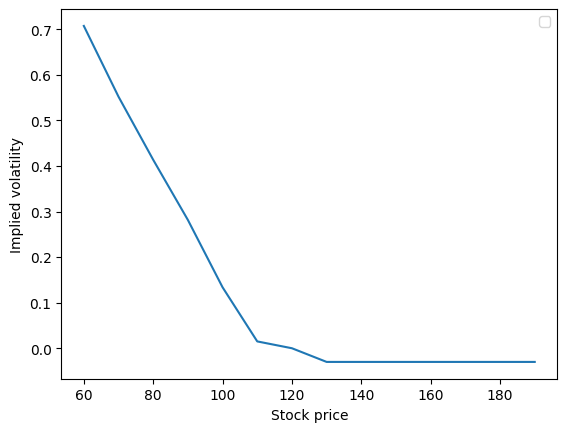

/tmp/ipykernel_32330/1717526037.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


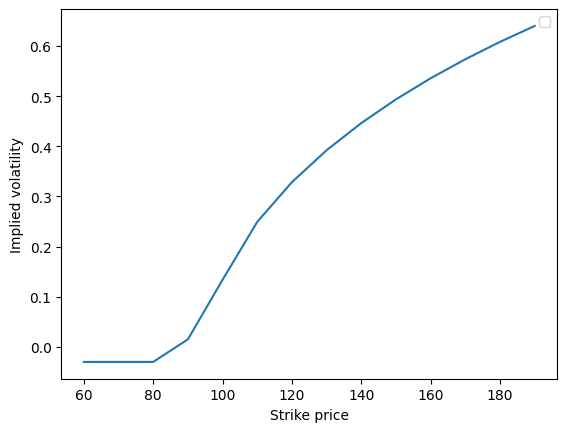

In [27]:
S = np.arange(60,200,10)
implied_vols = [implied_vol(St=St) for St in S]

plt.plot(S, implied_vols)
plt.xlabel("Stock price")
plt.ylabel("Implied volatility")
plt.legend()
plt.show()

Ks = np.arange(60,200,10)
implied_vols = [implied_vol(K=K) for K in Ks]

plt.plot(Ks, implied_vols)
plt.xlabel("Strike price")
plt.ylabel("Implied volatility")
plt.legend()
plt.show()

## Volatility surface

## Ressources
* https://accuratecalculators.com/options-calculator
* https://www.option-price.com/index.php